In this notebook, we'll use the open-sourced library lifelines to perform survival analysis on customer churn data. We will be using this analysis to infer the timing and factors that influence when customers leave

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import utils
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import os
from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
from lifelines.statistics import pairwise_logrank_test
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from lifelines import CoxPHFitter
from sklearn.preprocessing import StandardScaler
from lifelines.utils import concordance_index

In [2]:
# Read data from Cons_ID journey
data=pd.read_csv(r"C:\Users\nguyenta\OneDrive - Wolverine World Wide\Tam Nguyen\Project\SFMC\SFMC_EMAIL_ATTR_CLICKERS_SHOPPERS_TRANS.csv")
# data=pd.read_csv(r"C:\Users\nguyenta\Downloads\sample.csv")
data.head()

,CONS_ID,IP_ENROLL_DT,FIRST_PURCHASE_DT,EMAIL_SUBS,EMAIL_OPT_IN_DT,SMS_SUBS,SMS_OPT_IN_DT,VIP_STATUS,VIP_QUALIFYING_DT,VIP_EXPIRATION_DT,...,BOSS_TENURE,CC_TENURE,LT_DECILE,FY_DECILE,TY_DECILE,LY_DECILE,TY_NODE,TY_NODE_NM,LY_NODE,LY_NODE_NM
0,{3016988A-2D6C-4EDC-A5A8-3CD0DD339E0B},2019-03-27,2019-03-27,NaN,NaN,NaN,NaN,No,NaN,NaN,...,NaN,NaN,2.0,NaN,NaN,3.0,1110,CA09,1.0,CA08
1,{869207AC-A3EC-4115-A3EE-7DA1E6410E0B},2019-10-09,2019-10-09,NaN,NaN,NaN,NaN,No,NaN,NaN,...,NaN,NaN,6.0,NaN,NaN,NaN,1000,CA15,100.0,CA14
2,{B2F0D6AE-1CCA-4FE4-A387-1EDFA9C5FC63},2024-02-25,2024-02-25,Yes,2024-02-26,NaN,NaN,No,NaN,NaN,...,NaN,NaN,9.0,8.0,8.0,NaN,1000,CA15,NaN,NaN
3,{AF0B9F93-49BE-401D-819D-A7E87AA7928A},2019-06-14,2019-06-14,Yes,2018-09-24,NaN,NaN,No,NaN,NaN,...,NaN,NaN,7.0,NaN,NaN,NaN,0,CA16,0.0,CA16
4,{AB9E014C-CFF9-457A-A303-AF34822B4724},2024-04-14,2024-04-14,NaN,NaN,NaN,NaN,No,NaN,NaN,...,NaN,NaN,7.0,5.0,5.0,NaN,1000,CA15,NaN,NaN


In [4]:
data.shape

(18716342, 88)

In [5]:
# def categorize_recency(value):
#     if value=='New':
#         return 5
#     elif value=='Reactivated':
#         return 4
#     elif value=='Retained':
#         return 3
#     elif value=='Lapsed':
#         return 2
#     else:
#         return 1
# PREPROCESSING
# Tính số liệu Recency, Frequency and Monetary
data=data[data["LIFE_STAGE"]!= 'Sign Up - Not Activated']
data["LAST_VISIT_DT"]=pd.to_datetime(data['LAST_VISIT_DT'])
# data['recency']=data['LIFE_STAGE'].apply(categorize_recency)
data['recency']=data['LIFE_STAGE']
data['frequency']=data["TY_NODE_NM"].apply(lambda x: x[2:]).astype(int)
data['monetary']=data["TY_DECILE"]
data['TY_NET_SALES']=data['TY_NET_SALES'].apply(lambda x: 0 if x<0 else x)
data['TY_UNIT_CNT']=data['TY_UNIT_CNT'].apply(lambda x: 0 if x<0 else x)
data['FIRST_PURCHASE_DT']=pd.to_datetime(data['FIRST_PURCHASE_DT'])
data['LAST_VISIT_DT']=pd.to_datetime(data['LAST_VISIT_DT'])
data['churn']=data['LIFE_STAGE'].apply(lambda x: 1 if x=='Lapsed' else ('Unknown' if x=='Sign Up - Not Activated' else 0))

CALCULATE TENURE BASE ON CHURN STATUS

In [6]:
data['monetary']=data['monetary'].fillna(0)
current_date = datetime.strptime('2025-01-25', '%Y-%m-%d')
# Gap between first purchase to last purchase for Churn and Gap between first purchase to current date for Not Churn
# Tính toán "tenure" dựa trên trạng thái churn
data['gap_1']=(data['LAST_VISIT_DT']-data['FIRST_PURCHASE_DT']).dt.days
data['gap_2']=(current_date-data['FIRST_PURCHASE_DT']).dt.days

In [7]:
# data['tenure'] = data.apply(lambda row: row['gap_2'] if row['churn'] == 0 else row['gap_1'], axis=1)
data['tenure'] = np.where(data['churn'] == 0, data['gap_2'], data['gap_1'])

In [10]:
df=data[['CONS_ID','LIFE_STAGE','TY_NODE_NM','TY_NET_SALES','TY_TRANS_CNT','TY_POS_TRANS_CNT','TY_UNIT_CNT','TY_VISITS','DAYS_SINCE_LAST_VISIT','recency','frequency','monetary','tenure','churn']]
df=df.rename(columns={
    'CONS_ID':'Cons_ID',
    'LIFE_STAGE':'life_stage',
    'TY_NET_SALES':'TY_net_sales',
    'TY_TRANS_CNT':'TY_trans_cnt',
    'TY_POS_TRANS_CNT':'TY_pos_trans_cnt',
    'TY_UNIT_CNT':'TY_unit_cnt',
    'TY_VISITS':'TY_visits',
    'DAYS_SINCE_LAST_VISIT':'Days_since_last_visit'
})
df.head(100)

,Cons_ID,life_stage,TY_NODE_NM,TY_net_sales,TY_trans_cnt,TY_pos_trans_cnt,TY_unit_cnt,TY_visits,Days_since_last_visit,recency,frequency,monetary,tenure,churn
0,{3016988A-2D6C-4EDC-A5A8-3CD0DD339E0B},Lapsed,CA09,0.00,0,0,0.0,0,431.0,Lapsed,9,0.0,1700,1
1,{869207AC-A3EC-4115-A3EE-7DA1E6410E0B},Lapsed,CA15,0.00,0,0,0.0,0,1260.0,Lapsed,15,0.0,675,1
2,{B2F0D6AE-1CCA-4FE4-A387-1EDFA9C5FC63},New,CA15,39.94,1,1,6.0,1,335.0,New,15,8.0,335,0
3,{AF0B9F93-49BE-401D-819D-A7E87AA7928A},Lapsed,CA16,0.00,0,0,0.0,0,1874.0,Lapsed,16,0.0,178,1
4,{AB9E014C-CFF9-457A-A303-AF34822B4724},New,CA15,101.89,1,1,11.0,1,286.0,New,15,5.0,286,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,{5449021B-06C4-41FC-8C51-305CDDFAB1E3},Lapsed,CA12,0.00,0,0,0.0,0,440.0,Lapsed,12,0.0,1,1
103,{D816CEA1-6827-4968-A2F1-99939D9C78CD},Lapsed,CA10,0.00,0,0,0.0,0,726.0,Lapsed,10,0.0,74,1
104,{78CB9A6C-ED12-4AF2-B05C-A67D7C7E0CEE},Lapsed,CA14,0.00,0,0,0.0,0,933.0,Lapsed,14,0.0,0,1
105,{F37B3825-0937-4864-B82A-44C1C0B122C0},Reactivated,CA06,106.91,2,2,9.0,2,82.0,Reactivated,6,5.0,1813,0


REMOVE DATA WITH TENURE==0 && CHURN ==1

In [11]:
# REMOVE data có Tenure ==0 và churn==1
df=df[~((df['tenure'] == 0) & (df['churn'] == 1))]
# Mean and Median of Churn
events=df[['tenure','churn']]
naive_stat_1=(events.query("churn==1")["tenure"].apply(["median","mean"]))
print(f"Biased method 1 (removing censored points):\n"
     f"median: {naive_stat_1["median"]:.1f} days, "
     f"mean: {naive_stat_1["mean"]:.1f} days"
)
max_duration=events["tenure"].max()
naive_stat_2=(pd.Series(np.where(events['churn'],events['tenure'],max_duration)).apply(['mean','median']))
print(f"Biased method 2 (censored events moved to the end of the window):\n"
     f"median: {naive_stat_2["median"]:.1f} days, "
     f"mean: {naive_stat_2["mean"]:.1f} days"
)

Biased method 1 (removing censored points):
median: 546.0 days, mean: 685.5 days
Biased method 2 (censored events moved to the end of the window):
median: 2669.0 days, mean: 1788.7 days


In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
TY_net_sales,13175622.0,103.487584,383.920534,0.0,0.0,16.99,114.42,397800.4
TY_trans_cnt,13175622.0,1.506077,5.978546,0.0,0.0,1.00,2.00,5843.0
TY_pos_trans_cnt,13175622.0,1.339649,5.320230,0.0,0.0,1.00,2.00,5210.0
TY_unit_cnt,13175622.0,7.595317,25.727790,0.0,0.0,2.00,9.00,22565.0
TY_visits,13175622.0,1.297586,2.469123,0.0,0.0,1.00,2.00,337.0
Days_since_last_visit,13175622.0,516.722276,558.979695,0.0,83.0,293.00,787.00,2662.0
frequency,13175622.0,11.202124,3.820261,1.0,8.0,12.00,14.00,16.0
monetary,13175622.0,3.059109,3.472119,0.0,0.0,2.00,6.00,10.0
tenure,13175622.0,920.872522,774.468876,0.0,230.0,743.00,1512.00,2669.0
churn,13175622.0,0.443798,0.496831,0.0,0.0,0.00,1.00,1.0


<Axes: >

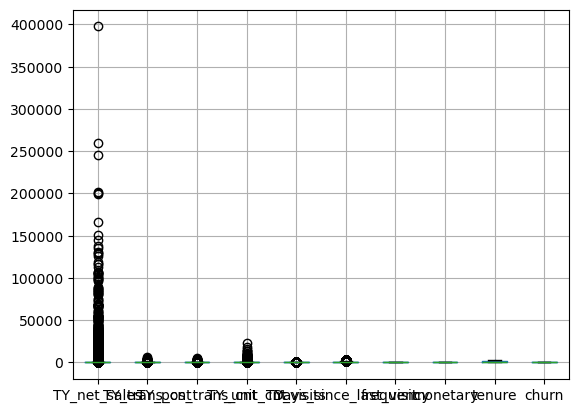

In [13]:
df.boxplot()

In [14]:
df.isnull().sum()

Cons_ID                  0
life_stage               0
TY_NODE_NM               0
TY_net_sales             0
TY_trans_cnt             0
TY_pos_trans_cnt         0
TY_unit_cnt              0
TY_visits                0
Days_since_last_visit    0
recency                  0
frequency                0
monetary                 0
tenure                   0
churn                    0
dtype: int64

In [15]:
df['churn'].value_counts()

churn
0    7328305
1    5847317
Name: count, dtype: int64

In [16]:
df.columns

Index(['Cons_ID', 'life_stage', 'TY_NODE_NM', 'TY_net_sales', 'TY_trans_cnt',
       'TY_pos_trans_cnt', 'TY_unit_cnt', 'TY_visits', 'Days_since_last_visit',
       'recency', 'frequency', 'monetary', 'tenure', 'churn'],
      dtype='object')

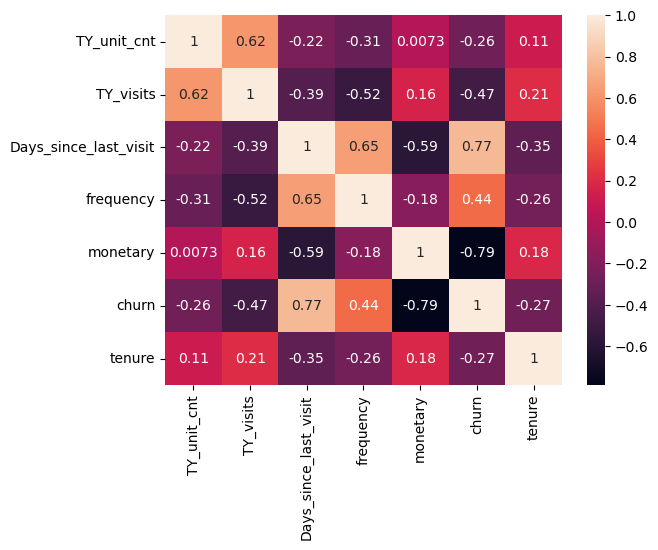

In [17]:
sns.heatmap(df[['TY_unit_cnt', 'TY_visits', 'Days_since_last_visit','frequency', 'monetary','churn','tenure']].corr(),annot=True)
plt.show()

#MÔ HÌNH KAPLANMEIER

The Kaplan-Meier curve will be estimating the survival probability of a customer from the time they start using the service to time T in days until they churn.

1487.0


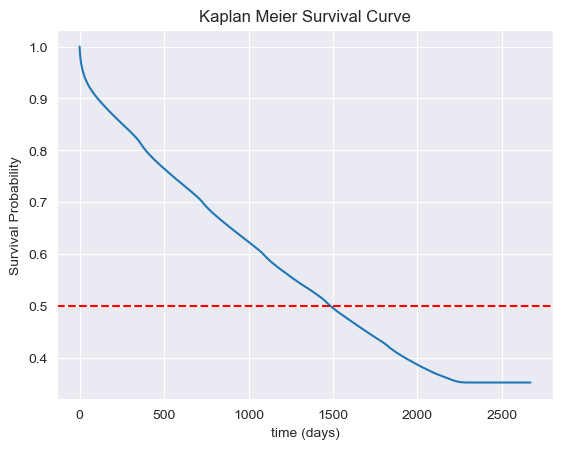

In [18]:
kmf = KaplanMeierFitter()
T=df['tenure']
C=df['churn'].astype(float)
kmf.fit(T,C)
print(kmf.median_survival_time_)
sns.set_style("darkgrid")
fig,ax=plt.subplots()
survival_probabilities=kmf.survival_function_.reset_index()
ax.plot(survival_probabilities['timeline'],survival_probabilities['KM_estimate'])
ax.axhline(0.5,linestyle="--",color="red",label="median")
ax.set(title="Kaplan Meier Survival Curve",xlabel="time (days)",ylabel="Survival Probability")
plt.show();

+ Downward Trend: The blue line representing the survival probability of customers decreases over time. This indicates that as time progresses, the likelihood of customers leaving the service increases. This is a common trend in churn analysis, where customers tend to leave the service after a certain period.

+ Median Survival Time: The red dashed horizontal line at the 0.5 level on the y-axis helps determine the median survival time. The intersection point between the blue curve and the red dashed line indicates the time at which 50% of the customers have churned, and 50% are still using product. The median survival time is a crucial metric for understanding customer behavior.

In [19]:
# survival_probabilities=kmf.survival_function_.reset_index()
# survival_probabilities
# times=survival_probabilities['timeline'].values
# km_estimate=survival_probabilities['KM_estimate'].values
# kmf.plot_survival_function().plot()
# plt.show()

PLOT KAMPLAN MEIER BY TY NODE

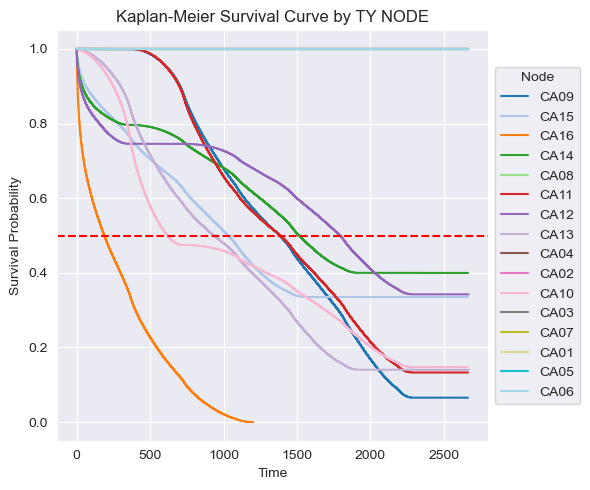

In [34]:
import matplotlib.cm as cm
categories = df['TY_NODE_NM'].unique()
colors = cm.get_cmap('tab20', len(categories))
plt.figure(figsize=(8, 5))
for i, category in enumerate(categories):
    mask = df['TY_NODE_NM'] == category
    kmf.fit(durations=df[mask]['tenure'], event_observed=df[mask]['churn'], label=category)
    kmf.plot_survival_function(ci_show=False, color=colors(i))
 # Thêm đường ngang ở mức 0.5
plt.axhline(y=0.5, color='red', linestyle='--')
plt.title('Kaplan-Meier Survival Curve by TY NODE')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.legend(title='Node', loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout(rect=[0, 0, 0.75, 1])
plt.show()

In [35]:
for category in categories:
    mask = df['TY_NODE_NM'] == category
    kmf.fit(durations=df[mask]['tenure'], event_observed=df[mask]['churn'])
    print(f"Category: {category}")
    print("\nMedian survival time:")
    print(kmf.median_survival_time_)
    print("\n")

Category: CA09

Median survival time:
1383.0


Category: CA15

Median survival time:
1032.0


Category: CA16

Median survival time:
188.0


Category: CA14

Median survival time:
1515.0


Category: CA08

Median survival time:
inf


Category: CA11

Median survival time:
1387.0


Category: CA12

Median survival time:
1792.0


Category: CA13

Median survival time:
933.0


Category: CA04

Median survival time:
inf


Category: CA02

Median survival time:
inf


Category: CA10

Median survival time:
618.0


Category: CA03

Median survival time:
inf


Category: CA07

Median survival time:
inf


Category: CA01

Median survival time:
inf


Category: CA05

Median survival time:
inf


Category: CA06

Median survival time:
inf




PLOT KAPLAN MEIER BY DECILE

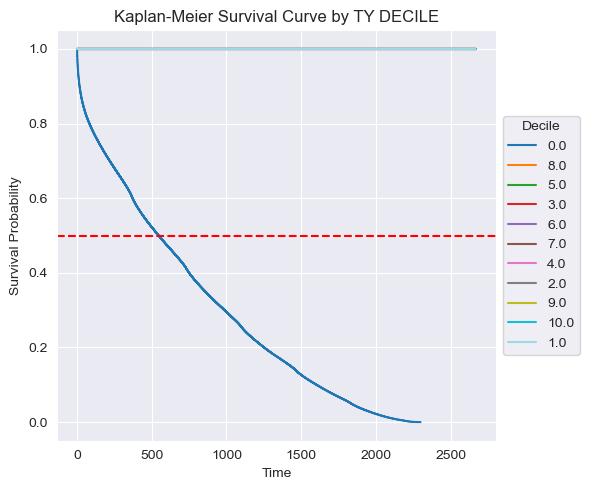

In [36]:
categories = df['monetary'].unique()
colors = cm.get_cmap('tab20', len(categories))
plt.figure(figsize=(8, 5))
for i, category in enumerate(categories):
    mask = df['monetary'] == category
    kmf.fit(durations=df[mask]['tenure'], event_observed=df[mask]['churn'], label=category)
    kmf.plot_survival_function(ci_show=False, color=colors(i))
 # Thêm đường ngang ở mức 0.5
plt.axhline(y=0.5, color='red', linestyle='--')
plt.title('Kaplan-Meier Survival Curve by TY DECILE')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.legend(title='Decile', loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout(rect=[0, 0, 0.75, 1])
plt.show()

TRAIN TEST SPLIT

In [38]:
# remove Outlier
# def remove_outlier(df,cols):
#     for col in cols:
#         q1=df[col].quantile(0.25)
#         q3=df[col].quantile(0.75)
#         iqr=q3-q1
#         lower=q1-1.5*iqr
#         upper=q3+1.5*iqr
#         df=df[(df[col]>=lower) &(df[col]<=upper)]
#     return df
# cols=['TY_net_sales','TY_unit_cnt','TY_visits']
# df=remove_outlier(df,cols)
data=df.copy()
# Log transform các biến lệch nhiều
data['log_net_sales']=np.log1p(data['monetary'])
data['log_unit_cnt']=np.log1p(data['TY_unit_cnt'])
data['log_days_last_visit']=np.log1p(data['Days_since_last_visit'])
data['log_tenure']=np.log1p(data['tenure'])
features=['log_net_sales', 'log_unit_cnt', 'log_days_last_visit','frequency']
# features=['log_net_sales', 'log_unit_cnt', 'log_days_last_visit','log_tenure','frequency']
X=data[['tenure','churn']+features]
# Chia train/test
train_df,test_df= train_test_split(X,
                                     test_size=0.2,
                                     random_state=42)
# STANDARDSCALER
train_df_scaled=train_df.copy()
test_df_scaled=test_df.copy()
sc=StandardScaler()
train_df_scaled[features]=pd.DataFrame(sc.fit_transform(train_df[features]),index=train_df.index)
test_df_scaled[features]=pd.DataFrame(sc.transform(test_df[features]),index=test_df.index)

In [39]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
TY_net_sales,13175622.0,103.487584,383.920534,0.0,0.000000,16.990000,114.420000,397800.400000
TY_trans_cnt,13175622.0,1.506077,5.978546,0.0,0.000000,1.000000,2.000000,5843.000000
TY_pos_trans_cnt,13175622.0,1.339649,5.320230,0.0,0.000000,1.000000,2.000000,5210.000000
TY_unit_cnt,13175622.0,7.595317,25.727790,0.0,0.000000,2.000000,9.000000,22565.000000
TY_visits,13175622.0,1.297586,2.469123,0.0,0.000000,1.000000,2.000000,337.000000
Days_since_last_visit,13175622.0,516.722276,558.979695,0.0,83.000000,293.000000,787.000000,2662.000000
frequency,13175622.0,11.202124,3.820261,1.0,8.000000,12.000000,14.000000,16.000000
monetary,13175622.0,3.059109,3.472119,0.0,0.000000,2.000000,6.000000,10.000000
tenure,13175622.0,920.872522,774.468876,0.0,230.000000,743.000000,1512.000000,2669.000000
churn,13175622.0,0.443798,0.496831,0.0,0.000000,0.000000,1.000000,1.000000


In [40]:
train_df_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,10540497.0,9.209420e+02,774.467423,0.000000,230.000000,743.000000,1512.000000,2669.000000
churn,10540497.0,4.437821e-01,0.496830,0.000000,0.000000,0.000000,1.000000,1.000000
log_net_sales,10540497.0,3.021100e-16,1.000000,-1.020496,-1.020496,0.131166,1.019378,1.493188
log_unit_cnt,10540497.0,4.935498e-16,1.000000,-0.930755,-0.930755,-0.086124,0.839510,6.776010
log_days_last_visit,10540497.0,-4.321979e-15,1.000000,-3.844432,-0.749287,0.125830,0.815429,1.665174
frequency,10540497.0,-1.788973e-16,1.000000,-2.670788,-0.838410,0.208663,0.732199,1.255735


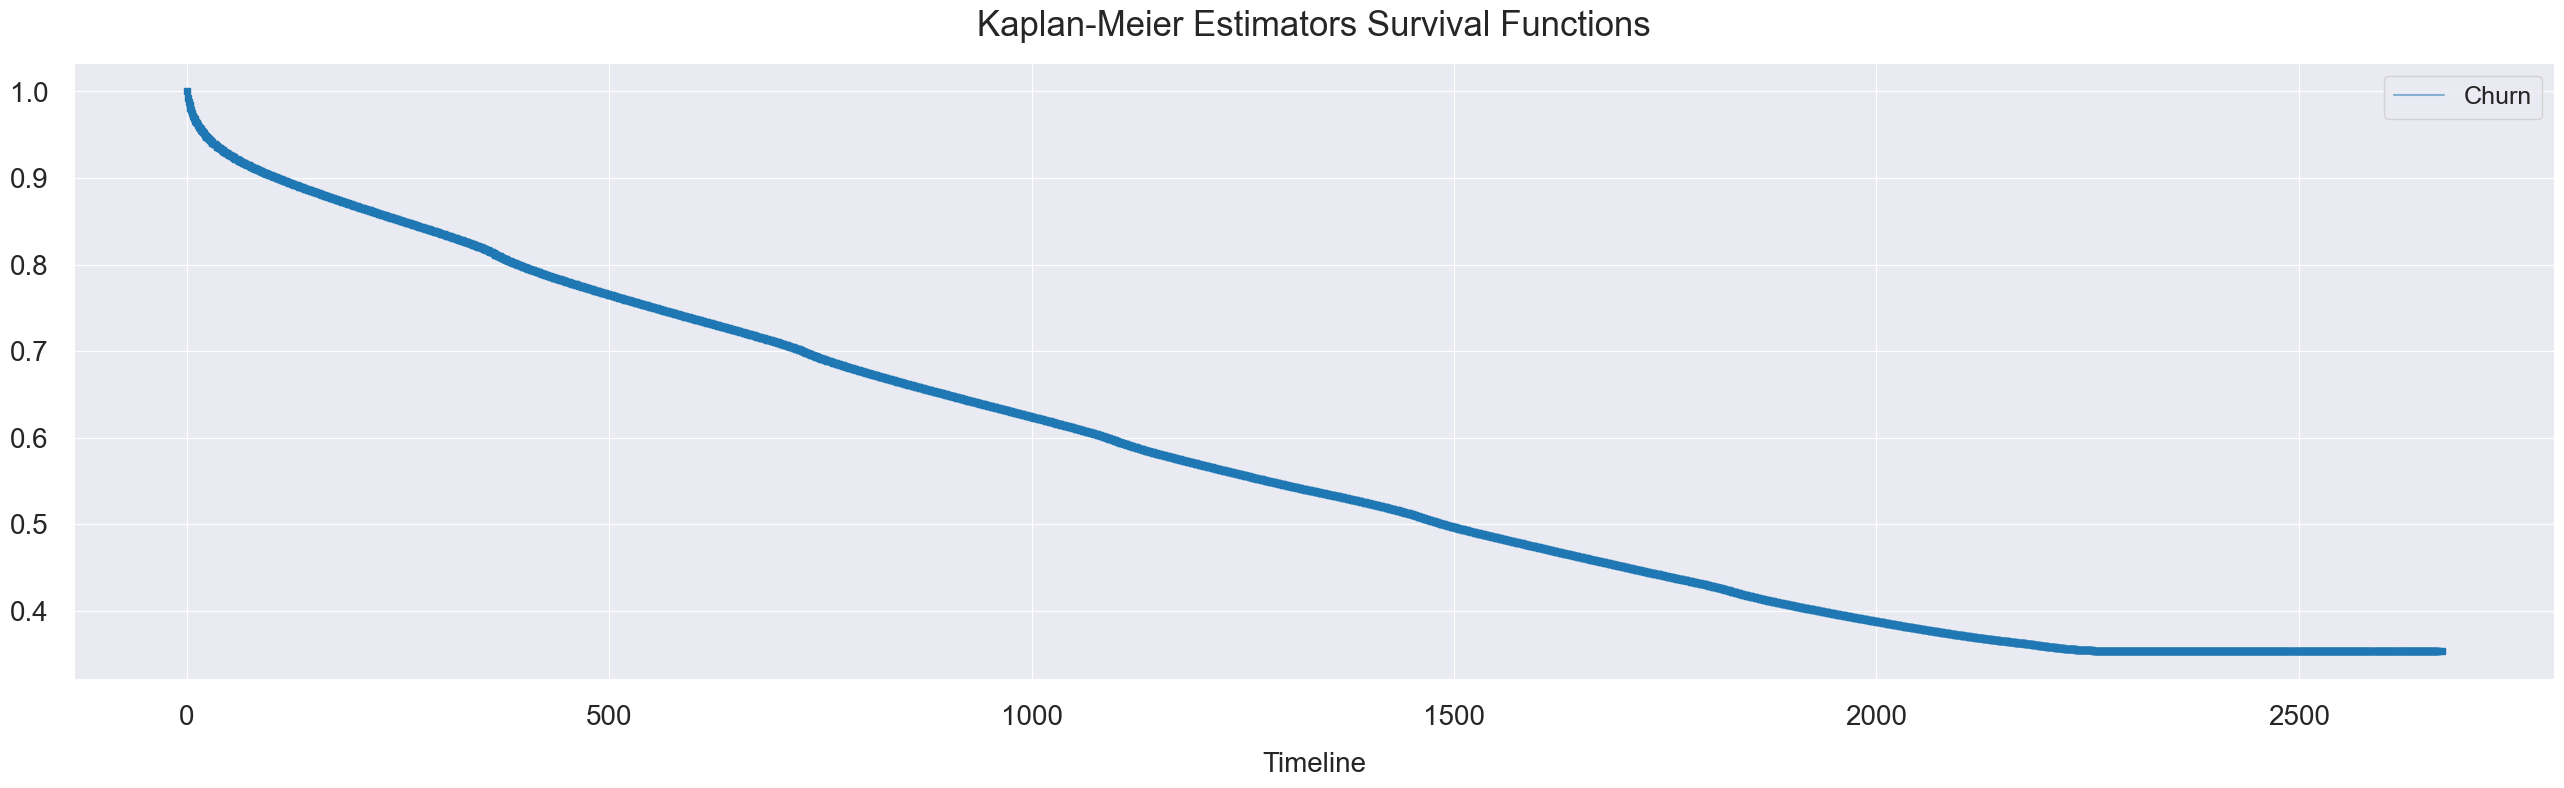

1487.0


In [41]:
# MÔ HÌNH KAPLAN MEIER VỚI TRAIN DATA SCALED
fig = plt.figure(figsize=(32, 8))
T, E = train_df['tenure'],train_df['churn']
kmf = KaplanMeierFitter()
kmf.fit(T, E)
kmf.plot(label='Churn', alpha=0.5, show_censors=True, censor_styles={'ms': 4, 'marker': 's'})
plt.xlabel('Timeline', size=20, labelpad=15)
plt.ylabel('')
plt.tick_params(axis='x', labelsize=20, pad=15)
plt.tick_params(axis='y', labelsize=20, pad=15)
plt.legend(prop={'size': 18})
plt.title('Kaplan-Meier Estimators Survival Functions', size=25, pad=20)
plt.show()
print(kmf.median_survival_time_)

In [42]:
train_df_scaled.isnull().sum()

tenure                 0
churn                  0
log_net_sales          0
log_unit_cnt           0
log_days_last_visit    0
frequency              0
dtype: int64

In [43]:
train_df_scaled[features]

,log_net_sales,log_unit_cnt,log_days_last_visit,frequency
8977876,0.131166,1.041219,-0.438865,-0.314874
17134877,-0.293878,1.543968,-0.412699,-0.576642
15452560,-1.020496,-0.930755,1.578126,1.255735
5725412,1.493188,-0.086124,-0.449612,0.208663
16811285,-1.020496,-0.930755,1.335436,1.255735
...,...,...,...,...
3173736,0.666658,0.758507,-0.209175,0.208663
6114690,-1.020496,-0.930755,0.433963,-0.053106
14320798,-1.020496,-0.930755,1.182811,0.993967
9305922,-1.020496,-0.930755,0.396279,-0.314874


COXPHFITTER MODEL

In [44]:
# MÔ HÌNH COXPHFITTER
cph=CoxPHFitter()
cph.fit(train_df_scaled,duration_col='tenure',event_col='churn')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 1.05405e+07 total observations, 5.86281e+06 right-censored observations>
             duration col = 'tenure'
                event col = 'churn'
      baseline estimation = breslow
   number of observations = 1.05405e+07
number of events observed = 4.67768e+06
   partial log-likelihood = -66543822.91
         time fit was run = 2025-05-07 07:20:24 UTC

---
                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                             
log_net_sales       -11.73      0.00     11.40          -34.06           10.61                0.00            40623.98
log_unit_cnt         -4.70      0.01     10.01          -24.32           14.93                0.00            3.06e+06
log_days_last_visit   1.44      4.23      0.00            1.44            1.45                4.21                4.26
frequency             0.18      1.20      0.00            0.18            0.18                1.19                1.20

                     cmp to      z      p  -log2(p)
covariate                                          
log_net_sales          0.00  -1.03   0.30      1.72
log_unit_cnt           0.00  -0.47   0.64      0.65
log_days_last_visit    0.00 455.58 <0.005       inf
frequency              0.00 104.84 <0.005       inf
---
Concordance = 0.86
Partial AIC = 133087653.83
log-likelihood ratio test = 11902243.58 on 4 df
-log2(p) of ll-ratio test = inf

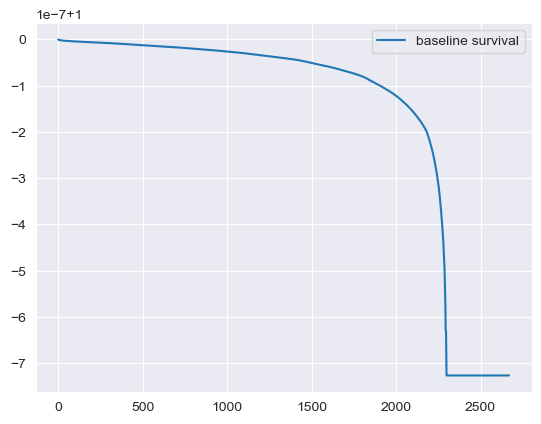

In [45]:
cph.baseline_survival_.plot()
# cph.baseline_survival_
# plt.ticklabel_format(style='plain', axis='y')
# plt.ylim(0.3,1)
plt.show()

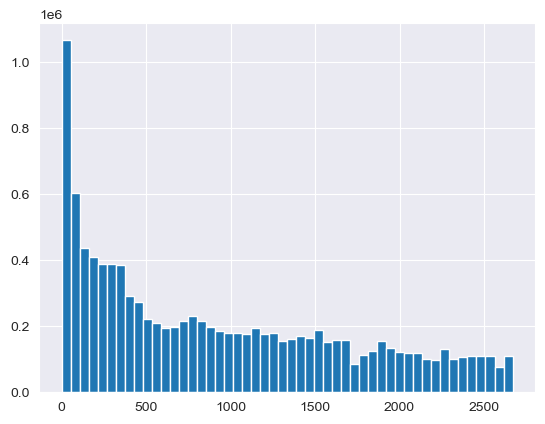

In [46]:
plt.hist(train_df_scaled['tenure'],bins=50)
plt.show()

In [47]:
survival_function = cph.predict_survival_function(test_df_scaled[:1000], times=np.arange(0,1000))
survival_function.T

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,990.0,991.0,992.0,993.0,994.0,995.0,996.0,997.0,998.0,999.0
18426416,1.0,0.987524,0.979788,0.974096,0.969263,0.964768,0.959954,0.954117,0.950208,0.947214,...,0.341861,0.341481,0.341070,0.340561,0.339941,0.339412,0.339003,0.338624,0.338235,0.337806
8984222,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
9458085,1.0,0.992956,0.988569,0.985332,0.982576,0.980008,0.977252,0.973902,0.971654,0.969928,...,0.546446,0.546103,0.545734,0.545275,0.544716,0.544238,0.543869,0.543526,0.543175,0.542787
1586691,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
14671294,1.0,0.976331,0.961790,0.951158,0.942174,0.933855,0.924985,0.914283,0.907150,0.901703,...,0.129004,0.128730,0.128435,0.128070,0.127625,0.127246,0.126954,0.126683,0.126406,0.126100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7501823,1.0,0.986322,0.977850,0.971620,0.966334,0.961419,0.956158,0.949782,0.945515,0.942246,...,0.308073,0.307697,0.307292,0.306789,0.306176,0.305653,0.305249,0.304874,0.304491,0.304067
379589,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1053691,1.0,0.992761,0.988253,0.984927,0.982096,0.979458,0.976627,0.973186,0.970877,0.969105,...,0.537340,0.536994,0.536620,0.536157,0.535592,0.535109,0.534736,0.534389,0.534034,0.533643
18533533,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [48]:
churn_threshold=0.5
def churn_time(df,threshold):
    churn_times=[]
    for index, row in df.iterrows():
        churn_time=None
        for col in df.columns:
            if col!='Cons_ID' and row[col]<threshold:
                churn_time=col
                break
        churn_times.append(churn_time)
    df['churn_time']=churn_times
    return df
survival_result=churn_time(survival_function.T,churn_threshold)
survival_result['churn_time']

18426416    689.0
8984222       NaN
9458085       NaN
1586691       NaN
14671294    339.0
            ...  
7501823     626.0
379589        NaN
1053691       NaN
18533533      NaN
18034866      NaN
Name: churn_time, Length: 1000, dtype: float64

In [49]:
# DỰ BÁO và ĐÁNH GIÁ
train_df_scaled['predict_hazard']=cph.predict_partial_hazard(train_df_scaled[features])
c_index_train=concordance_index(train_df_scaled['tenure']-train_df_scaled['predict_hazard'],train_df_scaled['churn'])
print(f"Train C Index:{c_index_train:.3f}")
# Test Prediction
test_df_scaled['predict_hazard']=cph.predict_partial_hazard(test_df_scaled[features])
c_index_test=concordance_index(test_df_scaled['tenure']-test_df_scaled['predict_hazard'],test_df_scaled['churn'])
print(f"Test C Index:{c_index_test:.3f}")

Train C Index:0.253
Test C Index:0.253


RandomSurvivalForest Model

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sksurv.ensemble import RandomSurvivalForest
# from sksurv.metrics import concordance_index_censored
# from sksurv.util import Surv

# # Giả sử bạn đã có DataFrame df
# # Cột 'tenure' là thời gian sống (duration)
# # Cột 'churn' là biến sự kiện (1 = churn, 0 = alive)
# # Đã log-transform các biến numerical như 'log_net_sales', 'log_unit_cnt', 'log_days_last_visit'

# # Tạo biến target theo định dạng required bởi scikit-survival
# y = Surv.from_dataframe("churn", "tenure", X)

# # Chọn feature để huấn luyện
# data_ = X[['log_net_sales', 'log_unit_cnt', 'log_days_last_visit', 'frequency']]

# # Chuẩn hóa dữ  liệu
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(data_)

# # Chia train-test
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# # Khởi tạo và huấn luyện Random Survival Forest
# rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=10,
#                            min_samples_leaf=15, max_features="sqrt",
#                            n_jobs=-1, random_state=42)
# rsf.fit(X_train, y_train)

# # Đánh giá mô hình trên tập test
# c_index = rsf.score(X_test, y_test)
# print(f"C-index trên test set: {c_index:.4f}")